# Frequency Interactions and Phase-Amplitude Coupling (PAC)

##### Sydney Smith 2018, Torben Noto 2015


#### Neural Oscillations can be embedded within each other.
There are many ongoing oscillations in the brain and **features of oscillations in different frequency bands can interact with each other**. Phase-amplitude coupling (PAC) measures how much the amplitude of a fast oscilation is related to the phase of a slower oscillation. This has been proposed as a mechanism that different brain regions may use to communicate.

In this notebook, we will:
1. Introduce the concept of PAC using complex sinusoid
2. Vizualize the relationship between phase and amplitude in the time domain
3. Discuss what PAC looks like in neural data
4. Explore PAC between theta (4-8 Hz) and HFA (80-150 Hz) in real ECoG data

I recommend that you read the [filtering](Filtering Link) and/or [PSD tutorials](PSD Link) before reading this if you are not familiar at all with filters and frequency analyses.

### Default Imports

Before we get started, let's import the python libraries with the functions we need to perform these analyses. 

In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
import scipy.signal
from scipy.signal import butter, filtfilt, hilbert

## 1. Phase-amplitude coupling (simulated)

If you're not familiar with signal processing, the concept of cross-frequency coupling, or phase-amplitude coupling (PAC) as it's known in neural data analysis, can be difficult to conceptualize. Before we look at PAC in real neural data, we'll simulate a signal in which PAC is occuring and then break it down into it's frequency components to investigate the phase-amplitude relationship.

##### PAC occurs when the frequency of a low frequency oscillation modulates the amplitude of a high frequency oscillation.

In the following cells, I'll generate a sinusoidal signal that has two frequency components, one slow (4 Hz) and one fast (100 Hz), where the amplitude of the fast component is changed by the phase of the slow component.

First, we'll make some variables for the two different frequencies, sampling rate, signal duration, and an array for the times associated with the amplitude values of the signal.

In [2]:
freq1 = 4 #Slow, modulating signal, 4 Hz
freq2 = 100 #Fast, modulated signal, 100 Hz
srate = 1024 #sampling rate
dur = 10 #10 seconds of signal
t = np.arange(0, dur, 1/srate) #times array

Now that we have our variables defined, let's generate and plot the amplitude-modulated signal.

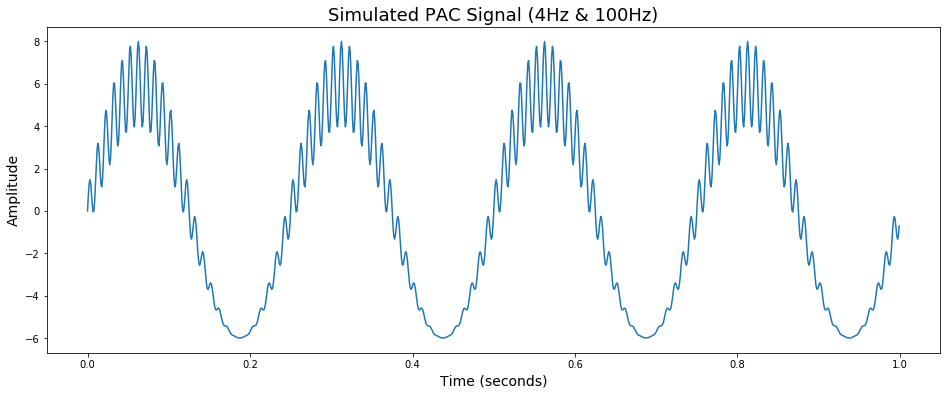

In [3]:
#Generate amplitude-modulated signal by combining 2 sinusoids
sim_signal = np.sin(2*np.pi*freq1*t)*np.sin(2*np.pi*freq2*t) + 6*np.sin(2*np.pi*freq1*t) + np.sin(2*np.pi*freq2*t)

#Plot 1 second of signal
plt.figure(figsize=(16,6))
plt.title('Simulated PAC Signal (4Hz & 100Hz)', size=18)
plt.xlabel('Time (seconds)', size=14)
plt.ylabel('Amplitude', size=14)
plt.plot(t[0:1024],sim_signal[0:1024])

At first glance, there seem to be two things going on in this signal: 

1. A larger wave that completes four cycles over the course of a second
2. A smalller, higher frequency wave that changes amplitude through time

We can identify **(1)** as the 4 Hz component. **(2)** has a much higher frequency (100 Hz) and its amplitude seems to fluctuate over time. Specifically, its amplitude is greatest at the peaks of the 4 Hz wave and almost non-existent at the troughs of the 4 Hz wave. From this information we can hypothesize that the phase of the 4 Hz wave and the amplitude 100 Hz wave are related.

Now that we have our hypothesis, we'll  take a closer look at the relationship between thes two frequency components in the signal.

## 2. Vizualizing phase and amplitude in the time domain using filters

Using filters, let's track the phase of the 4 Hz signal and the amplitude of the 100 Hz signal through time. If you need a refresher on filters, check out our [tutorial](LINK).

First, let's define our filtering functions.

In [4]:
#filtering functions
def butter_bandpass(lowcut, highcut, srate, order=4):
    """""
    lowcut: lower bound of the frequency that we want to isolate
    highcut: upper bound of the frequency that we want to isolate
    srate: sampling rate of our data
    """""
    nyq = 0.5 * srate #nyquist frequency 
    low = float(lowcut) / nyq
    high = float(highcut) / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(mydata, lowcut, highcut, srate, order=4):
    b, a = butter_bandpass(lowcut, highcut, srate, order=order)
    y = filtfilt(b, a, mydata)
    return y

#### Filter the generated signal
Now that we have our filters prepped and ready, let's apply them to the signal we generated. 

Let's start by filtering out the two frequency components in the signal. We'll do this by filtering the simulated signal through two butterworth bandpass filters, one filtering in a range of 2-6 Hz  to isolate our low frequency (4 Hz) component and the other filtering in a range of 80-110 Hz to isolate our high frequency component (100 Hz). 

In [5]:
#parameters
phase_band = [2,6] #4 Hz modulating frequency filter band
amplitude_band = [80,110] #100 Hz modulated frequency filter band

#isolate the slow component
phase_data_filt = butter_bandpass_filter(sim_signal, phase_band[0], phase_band[1], np.round(srate))

#isolate the fast component
amp_data_filt = butter_bandpass_filter(sim_signal, amplitude_band[0], amplitude_band[1], np.round(srate))

#### Plot the filtered signal

Here, we'll plot the outputs of the filters we just applied to the simulated signal. It will show us two signals overlayed so we can look at their relationship through time.

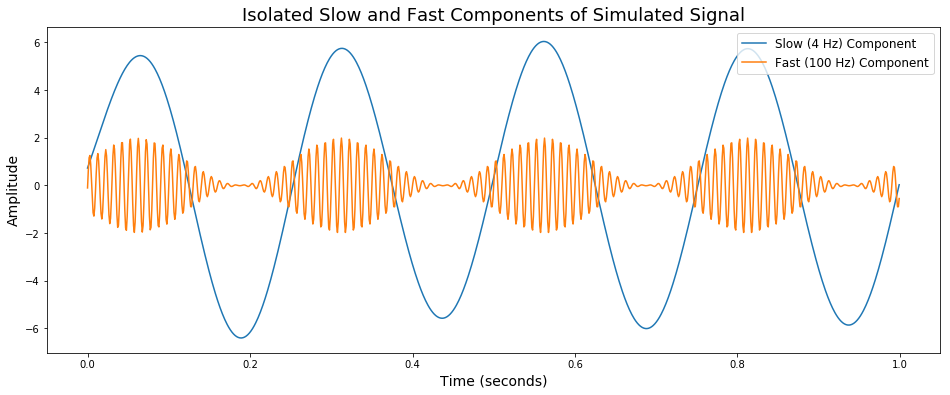

In [6]:
plt.figure(figsize=(16,6))
plt.title('Isolated Slow and Fast Components of Simulated Signal', size=18)
plt.xlabel('Time (seconds)', size=14)
plt.ylabel('Amplitude', size=14)
plt.plot(t[0:1024], phase_data_filt[0:1024], label='Slow (4 Hz) Component')
plt.plot(t[0:1024], amp_data_filt[0:1024], label='Fast (100 Hz) Component')
plt.legend(loc=1, fontsize=12)

When we overlay the filtered fast and slow components, we can see interesting "pulses" of high amplitude in the fast component that coincide with the peaks of the slow component.

Because it looks like the amplitude of the fast component wave is only occuring during a certain phase of the slow component wave, the next step is to plot the phase of the slow component and the amplitude envelope of the fast component through time. We'll do this using a Hilbert function.

#### Calculating phase and amplitude envelope 

The first function calculates the phase of the slow (4 Hz) component and the second calculates the amplitude envelope of the fast component (100 Hz).

In [7]:
#calculating phase angle of slow component
phase_data = hilbert(phase_data_filt)
phase_data = np.angle(phase_data)

#calculating amplitude envelope of fast component
amp_data = hilbert(amp_data_filt)
amp_data = abs(amp_data)

#### Plotting the outputs of the Hilbert function
When you look at the plot below, notice that the phase of the slow component is plotted between positive and negative π (3.14). Amplitude is plotted between 0 and 1. 

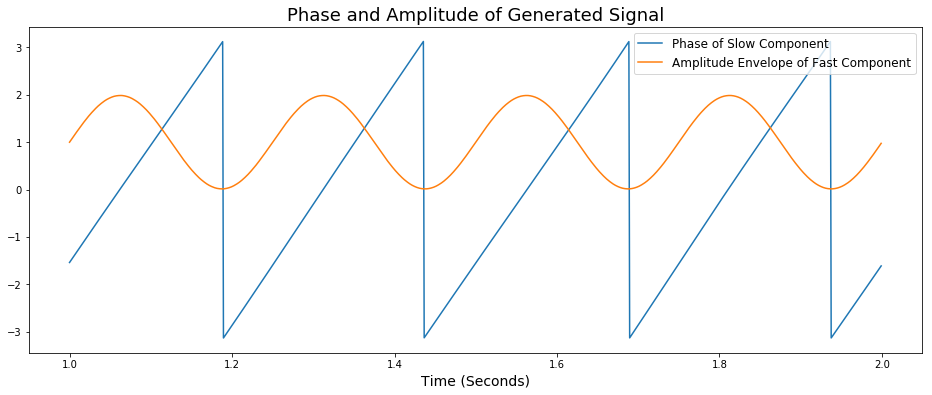

In [8]:
plt.figure(figsize=(16,6))
plt.plot(t[1024:2048], phase_data[1024:2048], label= 'Phase of Slow Component')
plt.plot(t[1024:2048], amp_data[1024:2048], label= 'Amplitude Envelope of Fast Component')
plt.title('Phase and Amplitude of Generated Signal', size=18)
plt.xlabel('Time (Seconds)', size=14)
plt.legend(loc=1, fontsize=12)

As we can see from the results of our filters, the phase of the slow (4 Hz) component cycles between -π to π four times in a second. We see a similar result for the amplitude envelope of the fast (100 Hz) component; it oscillates between 0 and 1 four times per second as well. The amplitude of the fast component is highest when the phase of the slow component equals zero (the peak of the slow wave) and lowest when the phase equals ±π (the trough of the slow wave). This vizualization makes it very clear that the amplitude of the 100 Hz component is directly related to the phase of the 4 Hz component. 

In other words, **the amplitude of the 100 Hz signal is coupled to the phase of the 4 Hz signal**. 

#### To summarize

In the last two sections we generated a signal in which the amplitude of a fast component was related to the phase of a slow component. We explored this relationship with two analyses:

1. Butterworth bandpass filtering to isolate the slow and fast frequency components
2. Applying a Hilbert function to plot the phase of the slow wave with the amplitude envelope of the fast wave

Using these two visual methods, we determined that in the simulated signal, the **amplitude** of the fast wave was *coupled* to the **phase** of the slow wave...

***Phase-Amplitude Coupling!***



## 3. PAC in neural data

In real electrophysiological data recorded from living brains, PAC is not as obvious as it was in our simulated signal. Although we can see some semblance of frequency interactions when we look at neural time series, most of the time the interaction is obscured by the presence of noise, low-frequency drift, artifacts, and other common characteristics of this kind of data. Not to mention that neural signals aren't always sinusoidal, but that's a story for another day (or another [tutorial](LINKTO#8)). 

For the sake of comparison, let's plot some real neural data and compare it to our simulated signal from earlier.

#### Load ECoG data

First, let's load some electrocorticography (ECoG) data and resample it at the same rate of our simulated signal (not necessary, just easier to work with).

In [9]:
#loading ECoG data from local save
path = 'dat/emodat.npy'
data = np.load(path)
fs = 1017.2533333333334

#resample at 1024 Hz
newsrate = 1024 # new sampling rate
ecog_signal = sp.signal.resample(data, int(np.floor(len(data)*(newsrate/fs))))

#### Plot ECoG data and simulated data

Plotting the ECoG data and the simulated data from the previous sections will let us compare them purely on a visual basis, highlighting the differences between what PAC looks like in simulations vs. real data.

Text(0.5,0,'Time (Seconds)')

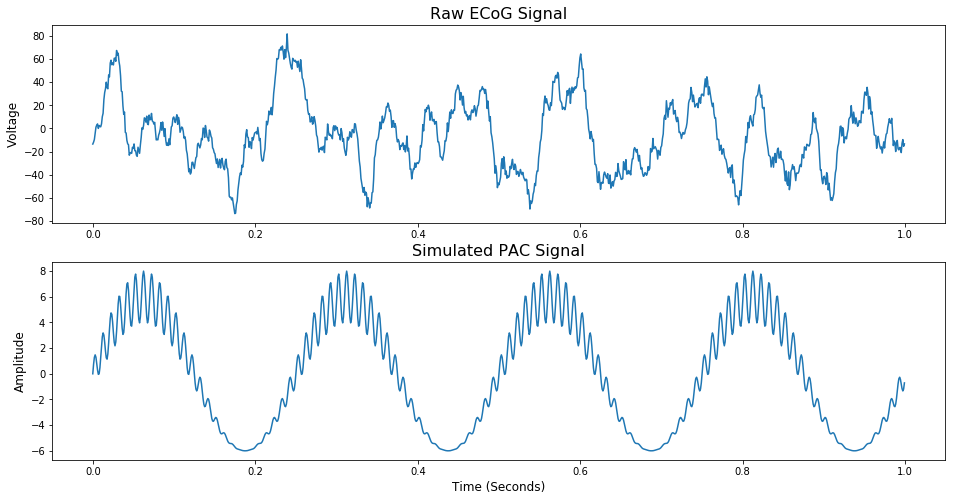

In [10]:
plt.figure(figsize=(16,8))

#Plot ECoG Signal
plt.subplot(2,1,1)
plt.plot(t[0:1024], ecog_signal[0:1024])
plt.title('Raw ECoG Signal', size=16)
plt.ylabel('Voltage', size=12)

#Plot Simulated Signal
plt.subplot(2,1,2)
plt.plot(t[0:1024], sim_signal[0:1024])
plt.title('Simulated PAC Signal', size=16)
plt.ylabel('Amplitude', size=12)
plt.xlabel('Time (Seconds)', size=12)

Even at first glance, these signals are obviousy VERY different. The ECoG signal looks irregular, jagged, and much more natural than the smooth, sinusoidal simulated signal. 

However, upon closer inspection, we can see some interesting similarities. For example, there does seem to be a slower oscillation within the ECoG signal. At some phases of this slow wave, there are some periods of high-frequency activity. 

So even though the signals look very different at first, it's possible that PAC could also exist in the ECoG signal. To investigate this further, let's run some of the same analyses from section 2 on the ECoG signal.

## 4. Visualizing PAC in ECoG data

In this section, we will filter and analyze the ECoG data we loaded in the previous section to see if PAC is present in the signal. In humans, PAC is common between oscillations in the theta (4-8 Hz) and high gamma (80-150 Hz) bands, so those frequency ranges will be the ones we use in our filter functions.

To filter the data, we can use the functions we defined in Section 2. 

In [11]:
#parameters
phase_band = [4,8] #4-8 Hz theta band (modulating frequency)
amplitude_band = [80,150] #80-150 Hz high gamma band (modulated frequency)

#isolate the slow component
phase_data_filt = butter_bandpass_filter(ecog_signal, phase_band[0], phase_band[1], np.round(srate))

#isolate the fast component
amp_data_filt = butter_bandpass_filter(ecog_signal, amplitude_band[0], amplitude_band[1], np.round(srate))

#### Plot the filtered ECoG data

Plotting the filtered data can let us look at the both the slow frequencies and the fast frequencies separately.

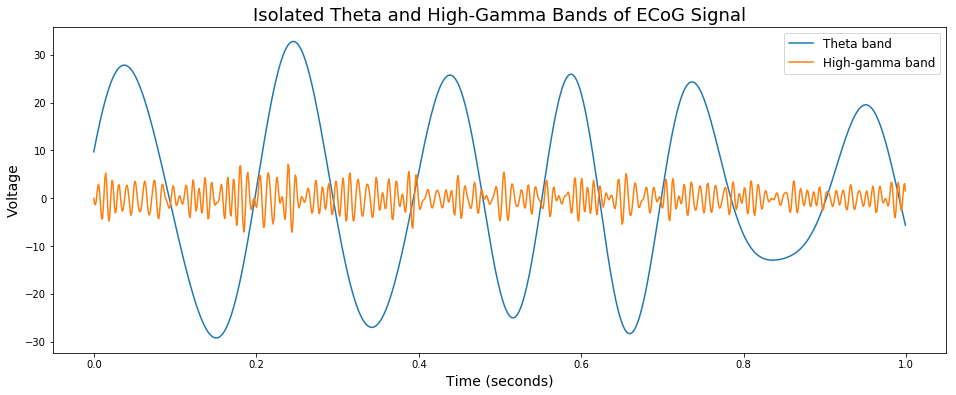

In [12]:
plt.figure(figsize=(16,6))
plt.title('Isolated Theta and High-Gamma Bands of ECoG Signal', size=18)
plt.xlabel('Time (seconds)', size=14)
plt.ylabel('Voltage', size=14)
plt.plot(t[0:1024], phase_data_filt[0:1024], label='Theta band')
plt.plot(t[0:1024], amp_data_filt[0:1024], label='High-gamma band')
plt.legend(loc=1, fontsize=12)

When we look at the plot above, we can see that there is a theta oscillation present in the signal that has a relatively high amplitude. We can also observe there is higher frequency activity in the high-gamma band. Although the amplitude of the gamma component does seem to change over time, if there is a pattern, it's not as clear as the one in our simulated signal. So let's run a Hilbert function and see if we can detect any correlations in gamma envelope and theta phase.

#### Calculate phase angle and amplitude envelope

Here we're using the same functions from section 2 on our ECoG data to calculate gamma amplitude envelope and theta phase angle.

In [13]:
#calculating phase angle of slow component
phase_data = hilbert(phase_data_filt)
phase_data = np.angle(phase_data)

#calculating amplitude envelope of fast component
amp_data = hilbert(amp_data_filt)
amp_data = abs(amp_data)

#### Plot phase and amplitude of ECoG data

Now that we've run our calculations, let's plot the result and see if we can visually detect any correlations.

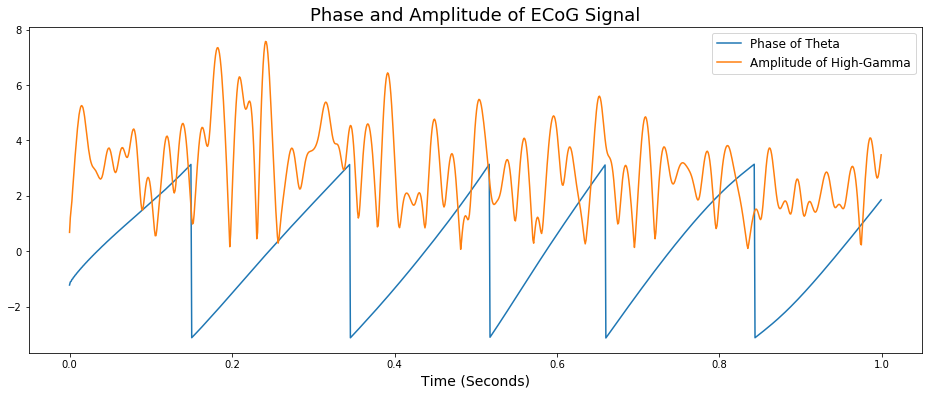

In [14]:
plt.figure(figsize=(16,6))
plt.plot(t[0:1024], phase_data[0:1024], label= 'Phase of Theta')
plt.plot(t[0:1024], amp_data[0:1024], label= 'Amplitude of High-Gamma')
plt.title('Phase and Amplitude of ECoG Signal', size=18)
plt.xlabel('Time (Seconds)', size=14)
plt.legend(loc=1, fontsize=12)

When we look at the figure above, what we need to focus on is the phase of theta and the height of the gamma envelope. Although it's not very clear at first glance, when you look closely, it's possible a positive correlation between these two measures. Specifically, it's seems like **the amplitude envelope of gamma is greatest when the phase angle of theta is close to zero**, or maybe slightly less than zero.

However, it would be silly to conclude that there is a relationship present based on this basic visual analysis. In order to determine if the relationship is present and significant, we should do some math and get a correlation value (r). 

#### Determine the strength of the correlation between theta phase and high-gamma amplitude envelope
Picking the right correlation function to use here is key because the data is periodic. A simple Pearson correlation cannot be used because the phase of theta is periodic (between -π and π) and a Pearson correlation, intended for linear data, would yeild inaccurate results.

To address this problem, we'll make a function that correctly correlates periodic data with linear data. Then, we'll run it on our data and get some correlation values.

In [15]:
def circCorr(ang,line):
    n = len(ang)
    rxs = sp.stats.pearsonr(line,np.sin(ang))
    rxs = rxs[0]
    rxc = sp.stats.pearsonr(line,np.cos(ang))
    rxc = rxc[0]
    rcs = sp.stats.pearsonr(np.sin(ang),np.cos(ang))
    rcs = rcs[0]
    rho = np.sqrt((rxc**2 + rxs**2 - 2*rxc*rxs*rcs)/(1-rcs**2)) #r
    r_2 = rho**2 #r squared
    pval = 1- sp.stats.chi2.cdf(n*(rho**2),1)
    standard_error = np.sqrt((1-r_2)/(n-2))

    return rho, pval, r_2,standard_error

print('Correlation Values:', circCorr(phase_data, amp_data))

Correlation Values: (0.05742430706754165, 0.0, 0.0032975510421873137, 0.0008190291715994757)


The values above represent the r, p, r^2 and standard of error respectively. These values show that there is a significant correlation between theta phase and high gamma amplitude that explains about 5% of the variance.

Now that we know that a significant correlation exists, we just need to determine what phase of theta the amplitude of gamma is coupled to. We can visualize that with a polar bar graph.

#### Visualize coupled phase

The polar historgram we will generate below will tell us where the greatest amounts of gamma amplitude are located in the theta wave. Discovering the phase of theta that contains the greatest amount of gamma amplitude will give us even more information about the PAC present in the ECoG signal. It's a lot of code but the result will be worth it, I promise.

(0, 1.6450675564956085)

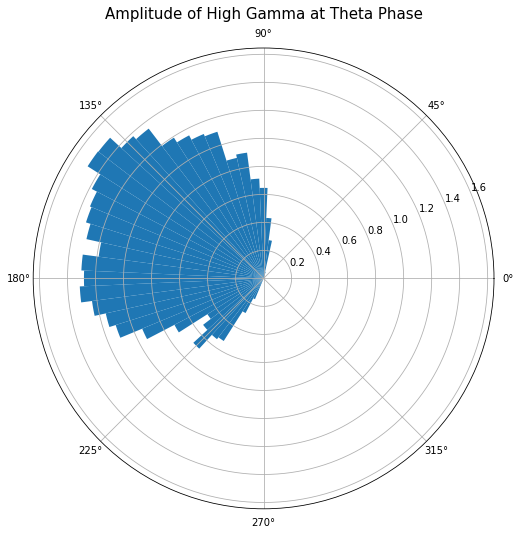

In [16]:
bin_size = 5 
bins = range(-180,180+bin_size,bin_size) 
bins = np.dot(bins, 0.0174532925)

amps = []

#filling phase bins with amplitudes
for x in range(len(bins)-1):
    amps_above_lo_bound = np.where(phase_data >= bins[x])[0]
    amps_below_hi_bound = np.where(phase_data < bins[x+1])[0]
    amps_below_hi_bound = set(amps_below_hi_bound)
    amp_inds_in_this_bin = [amp_val for amp_val in amps_above_lo_bound if amp_val in amps_below_hi_bound]
    amps_in_this_bin = amp_data[amp_inds_in_this_bin]
    amps.append(np.mean(amps_in_this_bin))

bins = bins[:len(bins)-1]

#normalizing to make the effect more clear
amps = (amps-np.mean(amps))/(np.std(amps))

#plotting figure
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
ax.bar(bins, amps, width=bins[1]-bins[0])
plt.title('Amplitude of High Gamma at Theta Phase', size=15)
plt.ylim(bottom=0)

In the figure above, the amplitude of high gamma steadily gets greater at around 135-180 degrees into the theta phase. This means that the amplitude of high gamma is greatest just following the peak of the theta wave. Remember that terms of a periodic signal, 180 degrees is equivalent to zero. 

If we look back at the last figure, the figure where we plotted theta phase and gamma amplitude, we can see that the gamma amplitude is greatest just before the phase of theta reaches zero. In other words, we can look at the two figures and see that they tell give us a similar result: gamma amplitude is greatest around the phase of theta at 135-180 degrees.

Therefore, we can conclude that in this ECoG signal the amplitude of high-gamma is coupled to the phase of theta. Our analysis shows that greatest gamma amplitudes occur in the first half of the descending phase, just after the theta peak. 

## In summary

In this tutorial, we learned that we can examine the relationship between the phase of a slow wave 
and the amplitude of a faster wave. To isolate the frequency ranges that we want, we use filters and useful mathematical functions to get the phase and amplitude of the waves that we're interested in. Then we can use statistics to quantify the relationship between the two.

In this example we have shown that, in our data, the amplitude of high gamma is biased to be greatest in the phase just following the peak of theta, demonstrating a phase-amplitude coupling realtionship. Our statistical analysis revealed that this is a small--but significant--correlation.

This tutorial was just an introduction to frequency interactions, specifically phase-amplitude coupling. In the brain, frequency interactions are hypothesized to serve a variety of functions including interregional communication, which is required for coordinated behaviors ranging from simple movement to high-level cognition. Although the mechanism behind frequency interactions is still undetermined, [Fries 2005](https://doi.org/10.1016/j.tics.2005.08.011) presents an excellent theory of neuronal coherence and I highly recommend reading it. 

There are several mathematical tools available that provide PAC measurements for time series data. You can find them in our lab's repository [NeuroDSP](https://github.com/voytekresearch/neurodsp). Feel free to check them out and try them on your own. Happy analyzing!
